In [1]:
import time
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config

from torchmetrics import Accuracy
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [2]:
df=pd.read_csv('/kaggle/input/byjus-data-clean/Byjus.csv')

In [3]:
df.shape

(18510, 30)

In [4]:
def convert_age(X):
    X = X.copy()
    X['age'] = pd.to_numeric(X['age'].astype(str).str.replace('+', '', regex=False), errors='coerce')
    X['age'] = pd.cut(X['age'], 
                      bins=[18, 22, 25, 28, 32, 35, float('inf')],
                      labels=['18-22', '23-25', '26-28', '29-32', '33-35', '35+'], 
                      right=True)
    return X

In [5]:
# Education mapping
education_mapping = {'engineering & technology': ['b.e / b-tech', 'bca/mca','m.e / m-tech', 'b.voc in networking and mobile applications', 
                                                  'b.arch', 'b.eng', 'b-tech', 'cse', 'bsc bedd - computer science', 'bachelors in engineering',
                                                  'food technology', 'biotechnology', 'masters in data science','mtech', 'btech', 'mca'],
                     
                     'bsc/msc': ['bsc', 'bsc or msc', 'bachelors in philosophy'],
                     'commerce & business': ['mba', 'b.com (bachelor of commerce)', 'b.com', 'b.comm', 'bba', 'bbm', 'bms', 'bachelor of business economics',
                                             'bcom computers','bms marketing', 'pgdm banking','bcom', 'bba or bbm', 'master in management'],
                     
                     'arts & humanities': ['ba', 'ba/ma', 'ma', 'bachelor mass communication', 'bachelors in design', 'bachelor of social work', 'bachelor in eco'],
                     'healthcare & medicine': ['b.pharma', 'med', 'bpharma', 'bds', 'b.physiotherapist', 'mbbs', 'pharma d', 'b -pharm', 'bachelor in medical lab', 'bachelor in dental'],
                     'social sciences': ['masters in social work', 'msw', 'masters in clinical psychology', 'masters in social science', 'masters in sociology'],
                     'diplomas & certifications': ['pgdm', 'pgdca', 'diploma', 'post graduation diploma', 'pgdf'],
                     'phd & doctorate': ['phd', 'doctorate',  'm.phil  2020'],
                     'vocational/technical': ['b.voc', 'vocational', 'bachelor of vocational','b voc - banking & finance'],
                     'hospitality & tourism': ['hotel management', 'masters in hospitality', 'tourism']}

def edu_function(degree):
    degree = str(degree).lower()
    for category, keywords in education_mapping.items():
        for keyword in keywords:
            if keyword.lower() in degree:
                return category
    return 'Other'

def categorize_degree(X):
    X = X.copy()
    X['Education'] = X['Education'].str.lower().fillna('Other')
    X['Education'] = X['Education'].apply(edu_function)
    return X

In [6]:
for col in df.columns:
    if df[col].nunique()>10:
        continue
    print(f"{col}----{df[col].nunique()}")

gender----2
marital_status----3
interview_mode----2
mother_tongue_influence_in_english----2
Anyone_spoken_before_applying----2
candidate_status----4
last_fixed_ctc_(lakhs)----8
currently_employed----2
experience_in_months----8
what_was_the_type_of_role?----3
how_many_slides_candidate_have_submitted_in_ppt?----8
role_acceptance----3
interview_verdict----5
candidate_is_willing_to_relocate----4
confidence_based_on_introduction_(english)----3
confidence_based_on_the_topic_given__----3
confidence_based_on_the_ppt_question----3
confidence_based_on_the_sales_scenario----3
structured_thinking_(in_regional_only)----3
structured_thinking_based_on_the_ppt_question----3
structured_thinking(_call_pitch)----3
regional_fluency_based_on_the_topic_given__----4
regional_fluency_based_on_the_ppt_question----4
regional_fluency_based_on_the__sales_scenario----4
confidence_score----9
structured_thinking_score----7
regional_fluency_score----10


In [7]:
def label_encoder(X):
    X = X.copy()
    label_encoders = {}
    categorical_cols = ['gender',
                        'marital_status',
                        'interview_mode', 
                        'mother_tongue_influence_in_english',
                        'Anyone_spoken_before_applying', 
                        'currently_employed',
                        'candidate_status']

    for col in categorical_cols:
        X[col] = X[col].fillna('Unknown')
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le
    return X

In [8]:
df['interview_verdict'] = df['interview_verdict'].replace({'Premium Select': 'Select', 'Borderline Select': 'Select', 'Borderline Reject': 'Reject'})

In [9]:
# Label encode the target
le_verdict = LabelEncoder()
df['interview_verdict'] = le_verdict.fit_transform(df['interview_verdict'])


In [10]:
numerical_cols = ['confidence_based_on_introduction_(english)',
                  'confidence_based_on_the_topic_given__',
                  'confidence_based_on_the_ppt_question',
                  'confidence_based_on_the_sales_scenario',
                  'structured_thinking_(in_regional_only)',
                  'structured_thinking_based_on_the_ppt_question',
                  'structured_thinking(_call_pitch)',
                  'regional_fluency_based_on_the_topic_given__',
                  'regional_fluency_based_on_the_ppt_question',
                  'regional_fluency_based_on_the__sales_scenario',
                  'confidence_score',
                  'structured_thinking_score',
                  'regional_fluency_score',
                  'total_score'
                 ]

categorical_cols = ['Education',
                    'gender',
                    'marital_status',
                    'interview_mode',
                    'mother_tongue_influence_in_english',
                    'Anyone_spoken_before_applying',
                    'currently_employed',
                    'candidate_status', 
                    'candidate_is_willing_to_relocate',
                    'last_fixed_ctc_(lakhs)', 
                    'experience_in_months',
                    'what_was_the_type_of_role?',
                    'how_many_slides_candidate_have_submitted_in_ppt?', 
                    'role_acceptance', 
                    'age']

preprocessing_pipeline = Pipeline([('convert_age', FunctionTransformer(convert_age, validate=False)),
                                   ('categorize_education', FunctionTransformer(categorize_degree, validate=False)),
                                   ('label_encoder', FunctionTransformer(label_encoder, validate=False)),
                                   ('encode_scale', ColumnTransformer(transformers=[
                                       ('onehot', OneHotEncoder(sparse_output=False, drop='first'), categorical_cols),        #  One-hot encode categorical features
                                       ('scaler', StandardScaler(), numerical_cols)                                           #  StandardScaler for all numerical columns
                                   ], remainder='passthrough'))
                                  ])

In [11]:
# Display the pipeline diagram
set_config(display='diagram')
preprocessing_pipeline

Pipeline(steps=[('convert_age',
                 FunctionTransformer(func=<function convert_age at 0x7b6bb5dca560>)),
                ('categorize_education',
                 FunctionTransformer(func=<function categorize_degree at 0x7b6bb5dcb130>)),
                ('label_encoder',
                 FunctionTransformer(func=<function label_encoder at 0x7b6bb5dcb1c0>)),
                ('encode_scale',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('o...
                                                   'structured_thinking_(in_regional_only)',
                                                   'structured_thinking_based_on_the_ppt_question',
                                                   'structured_thinking(_call_pitch)',
                                                   'regional_fluency_based_on_the_topic_given__',
                                                   'regional_fluency_based_on_the_ppt_question',
                                                   'regional_fluency_based_on_the__sales_scenario',
                                                   'confidence_score',
                                                   'structured_thinking_score',
                                                   'regional_fluency_score',
                                                   'total_score'])]))])

In [12]:
# Splitting the data
X = df.drop(columns=['interview_verdict']).copy()
y = df['interview_verdict']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
preprocessing_pipeline.fit(X_train, y_train)

Pipeline(steps=[('convert_age',
                 FunctionTransformer(func=<function convert_age at 0x7b6bb5dca560>)),
                ('categorize_education',
                 FunctionTransformer(func=<function categorize_degree at 0x7b6bb5dcb130>)),
                ('label_encoder',
                 FunctionTransformer(func=<function label_encoder at 0x7b6bb5dcb1c0>)),
                ('encode_scale',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('o...
                                                   'structured_thinking_(in_regional_only)',
                                                   'structured_thinking_based_on_the_ppt_question',
                                                   'structured_thinking(_call_pitch)',
                                                   'regional_fluency_based_on_the_topic_given__',
                                                   'regional_fluency_based_on_the_ppt_question',
                                                   'regional_fluency_based_on_the__sales_scenario',
                                                   'confidence_score',
                                                   'structured_thinking_score',
                                                   'regional_fluency_score',
                                                   'total_score'])]))])

In [15]:
X_train.shape

(14808, 29)

In [16]:
# Fit and transform with pipeline
X_train_processed = preprocessing_pipeline.fit_transform(X_train, y_train)
X_test_processed = preprocessing_pipeline.transform(X_test)

In [17]:
X_train_processed.shape

(14808, 64)

# Working on NN

In [18]:
# Convert to NumPy array and float32
y_train_array = np.array(y_train).astype(np.float32)
y_test_array = np.array(y_test).astype(np.float32)

# Convert the preprocessed data into PyTorch tensors
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)

# Convert the target variables into PyTorch tensors
y_train_tensor = torch.tensor(y_train_array, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_array, dtype=torch.float32)

In [19]:
# Confirm the shapes
print(f"X_train_tensor shape: {X_train_tensor.shape}, y_train_tensor shape: {y_train_tensor.shape}")
print(f"X_test_tensor shape: {X_test_tensor.shape}, y_test_tensor shape: {y_test_tensor.shape}")


X_train_tensor shape: torch.Size([14808, 64]), y_train_tensor shape: torch.Size([14808])
X_test_tensor shape: torch.Size([3702, 64]), y_test_tensor shape: torch.Size([3702])


In [20]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [21]:
from torch.utils.data import DataLoader

# Create dataset instances
train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
test_dataset = CustomDataset(X_test_tensor, y_test_tensor)

# Define DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [22]:
import torch.nn as nn
class CandidateRankingModel(nn.Module):
    def __init__(self, input_dim):
        super(CandidateRankingModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = torch.sigmoid(self.fc3(x))
        return x

In [23]:
# Instantiate the model
input_dim = X_train_tensor.shape[1]
model = CandidateRankingModel(input_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [24]:
input_dim

64

In [25]:
# Check if model and data pipeline are working correctly
model.train()
for batch_X, batch_y in train_loader:
    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
    
    # Forward pass
    outputs = model(batch_X)
    print("Batch shape:", batch_X.shape)
    print("Output shape:", outputs.shape)
    print("Sample output:", outputs[:5])
    
    break

Batch shape: torch.Size([64, 64])
Output shape: torch.Size([64, 1])
Sample output: tensor([[0.4316],
        [0.5159],
        [0.3701],
        [0.3587],
        [0.4618]], device='cuda:0', grad_fn=<SliceBackward0>)


In [26]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_labels = []
    all_preds = []

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)

        # Reshape target to match the output shape
        batch_y = batch_y.view(-1, 1)

        # Compute loss
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Store predictions and labels for metrics calculation
        preds = (outputs >= 0.5).float()  # Threshold at 0.5 for binary classification
        all_preds.extend(preds.cpu().detach().numpy())
        all_labels.extend(batch_y.cpu().detach().numpy())

    avg_loss = running_loss / len(train_loader)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc_roc = roc_auc_score(all_labels, all_preds)

    return avg_loss, accuracy, precision, recall, f1, auc_roc


In [27]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            outputs = model(batch_X)

            # Reshape target to match the output shape
            batch_y = batch_y.view(-1, 1)

            loss = criterion(outputs, batch_y)
            running_loss += loss.item()

            preds = (outputs >= 0.5).float()
            all_preds.extend(preds.cpu().detach().numpy())
            all_labels.extend(batch_y.cpu().detach().numpy())

    avg_loss = running_loss / len(test_loader)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc_roc = roc_auc_score(all_labels, all_preds)

    return avg_loss, accuracy, precision, recall, f1, auc_roc

In [28]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
train_precisions = []
test_precisions = []
train_recalls = []
test_recalls = []
train_f1_scores = []
test_f1_scores = []
train_auc_roc = [] 
test_auc_roc = []

torch.manual_seed(42)
epochs = 30
start_time = time.time()

for epoch in range(1, epochs + 1):
    train_loss, train_accuracy, train_precision, train_recall, train_f1_score, train_auc_roc_value = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy, test_precision, test_recall, test_f1_score, test_auc_roc_value = evaluate(model, test_loader, criterion, device)

    # Store metrics for plotting
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    train_precisions.append(train_precision)
    test_precisions.append(test_precision)
    train_recalls.append(train_recall)
    test_recalls.append(test_recall)
    train_f1_scores.append(train_f1_score)
    test_f1_scores.append(test_f1_score)
    train_auc_roc.append(train_auc_roc_value)
    test_auc_roc.append(test_auc_roc_value)

    # Print epoch results
    print("Training Started...!!")
    print(f"\nEpoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Acc: {train_accuracy:.4f} | Test Acc: {test_accuracy:.4f}")
    print(f"Train Precision: {train_precision:.4f} | Test Precision: {test_precision:.4f} | Train Recall: {train_recall:.4f} | Test Recall: {test_recall:.4f}")
    print(f"Train F1 Score: {train_f1_score:.4f} | Test F1 Score: {test_f1_score:.4f} | Train AUC-ROC: {train_auc_roc_value:.4f} | Test AUC-ROC: {test_auc_roc_value:.4f}")

end_time = time.time()
print(f"\nTraining completed in {end_time - start_time:.2f} seconds.")

Training Started...!!

Epoch 1/30
Train Loss: 0.6208 | Test Loss: 0.5250 | Train Acc: 0.6312 | Test Acc: 0.7685
Train Precision: 0.9197 | Test Precision: 0.9358 | Train Recall: 0.5658 | Test Recall: 0.7496
Train F1 Score: 0.7006 | Test F1 Score: 0.8324 | Train AUC-ROC: 0.7036 | Test AUC-ROC: 0.7902
Training Started...!!

Epoch 2/30
Train Loss: 0.4560 | Test Loss: 0.4303 | Train Acc: 0.8203 | Test Acc: 0.8485
Train Precision: 0.9046 | Test Precision: 0.9139 | Train Recall: 0.8544 | Test Recall: 0.8859
Train F1 Score: 0.8788 | Test F1 Score: 0.8997 | Train AUC-ROC: 0.7826 | Test AUC-ROC: 0.8056
Training Started...!!

Epoch 3/30
Train Loss: 0.3947 | Test Loss: 0.3695 | Train Acc: 0.8459 | Test Acc: 0.8628
Train Precision: 0.8888 | Test Precision: 0.8968 | Train Recall: 0.9121 | Test Recall: 0.9278
Train F1 Score: 0.9003 | Test F1 Score: 0.9120 | Train AUC-ROC: 0.7728 | Test AUC-ROC: 0.7883
Training Started...!!

Epoch 4/30
Train Loss: 0.3651 | Test Loss: 0.3516 | Train Acc: 0.8556 | Test 

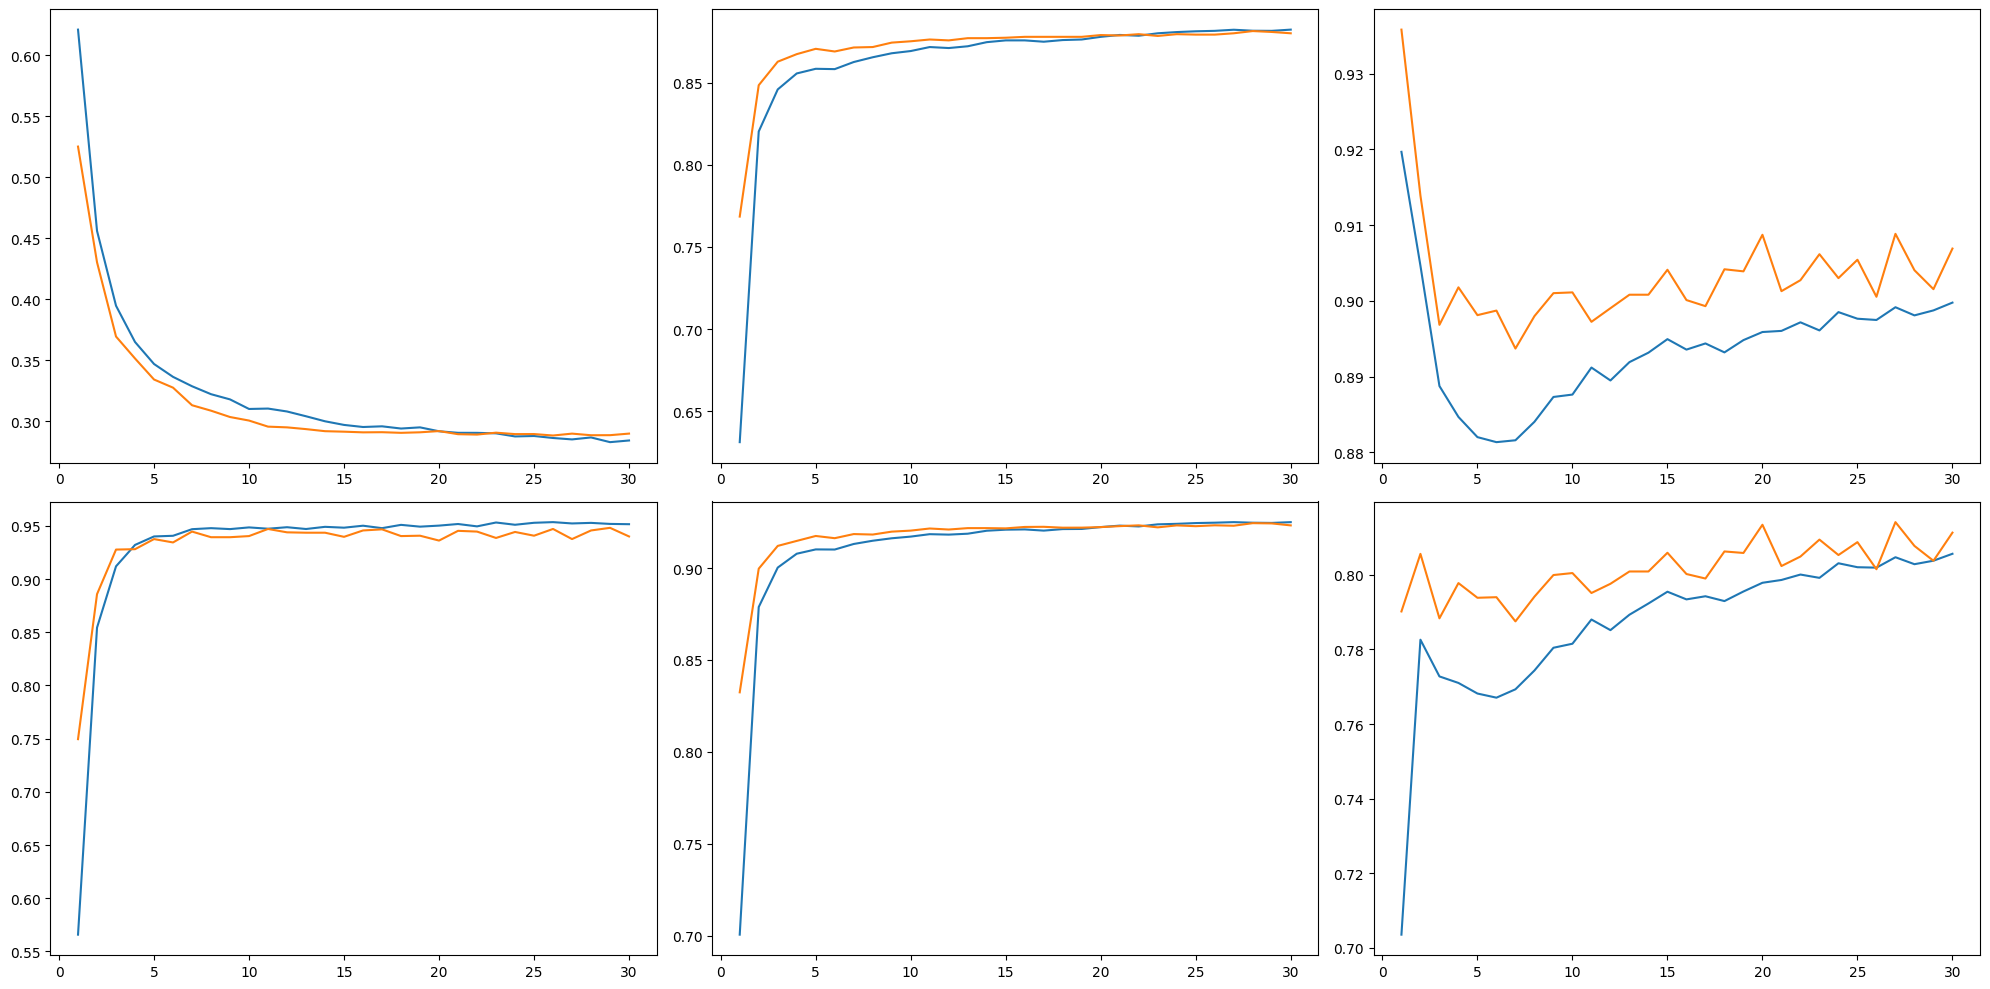

In [29]:
# Plotting the metrics
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')

# Plot Accuracy
plt.subplot(2, 3, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy')


# Plot Precision
plt.subplot(2, 3, 3)
plt.plot(epochs_range, train_precisions, label='Train Precision')
plt.plot(epochs_range, test_precisions, label='Test Precision')

# Plot Recall
plt.subplot(2, 3, 4)
plt.plot(epochs_range, train_recalls, label='Train Recall')
plt.plot(epochs_range, test_recalls, label='Test Recall')

# Plot F1 Score
plt.subplot(2, 3, 5)
plt.plot(epochs_range, train_f1_scores, label='Train F1 Score')
plt.plot(epochs_range, test_f1_scores, label='Test F1 Score')


# Plot AUC-ROC
plt.subplot(2, 3, 6)
plt.plot(epochs_range, train_auc_roc, label='Train AUC-ROC')
plt.plot(epochs_range, test_auc_roc, label='Test AUC-ROC')

plt.tight_layout()
plt.show()

In [30]:
model_path = "CandidateRanking.pth"
torch.save(model.state_dict(), model_path)
print(f"Full model saved at: {model_path}")

Full model saved at: CandidateRanking.pth


In [31]:
# num_features = X_train_tensor.shape[1]
# hidden_units = 128

# # Assuming `model` is your trained model
# model_path = "CandidateRankingModel_with_param.pth"
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'num_features': num_features,
#     'hidden_units': hidden_units,
# }, model_path)

# print(f"Model and parameters saved at: {model_path}")